<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span><ul class="toc-item"><li><span><a href="#Outils" data-toc-modified-id="Outils-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Outils</a></span></li><li><span><a href="#Lecture-du-dataframe" data-toc-modified-id="Lecture-du-dataframe-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Lecture du dataframe</a></span><ul class="toc-item"><li><span><a href="#Creation-d'un-dataframe-debug-equilibré" data-toc-modified-id="Creation-d'un-dataframe-debug-equilibré-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Creation d'un dataframe debug equilibré</a></span></li></ul></li></ul></li><li><span><a href="#Choix-d'un-modèle" data-toc-modified-id="Choix-d'un-modèle-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Choix d'un modèle</a></span><ul class="toc-item"><li><span><a href="#Roc-auc" data-toc-modified-id="Roc-auc-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Roc auc</a></span><ul class="toc-item"><li><span><a href="#split-des-données-en-Train-et-Test" data-toc-modified-id="split-des-données-en-Train-et-Test-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>split des données en Train et Test</a></span></li><li><span><a href="#Plot-de-la-courbe-ROC-pour-les-différents-modèles-testés" data-toc-modified-id="Plot-de-la-courbe-ROC-pour-les-différents-modèles-testés-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Plot de la courbe ROC pour les différents modèles testés</a></span><ul class="toc-item"><li><span><a href="#Sur-les-données-telles-quelles" data-toc-modified-id="Sur-les-données-telles-quelles-2.1.2.1"><span class="toc-item-num">2.1.2.1&nbsp;&nbsp;</span>Sur les données telles quelles</a></span></li><li><span><a href="#Sur-les-données-debug-equilibrés" data-toc-modified-id="Sur-les-données-debug-equilibrés-2.1.2.2"><span class="toc-item-num">2.1.2.2&nbsp;&nbsp;</span>Sur les données debug equilibrés</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Test-avec-Synthetic-Minority-Oversampling-TEchnique-(SMOTE)" data-toc-modified-id="Test-avec-Synthetic-Minority-Oversampling-TEchnique-(SMOTE)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test avec Synthetic Minority Oversampling TEchnique (SMOTE)</a></span></li><li><span><a href="#Test-de-LGBM-sans-preprocessing" data-toc-modified-id="Test-de-LGBM-sans-preprocessing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test de LGBM sans preprocessing</a></span></li><li><span><a href="#LGBM-permutation-importance-avec-ELI5" data-toc-modified-id="LGBM-permutation-importance-avec-ELI5-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>LGBM permutation importance avec ELI5</a></span></li><li><span><a href="#Bibliography" data-toc-modified-id="Bibliography-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Bibliography</a></span></li></ul></div>

# Import


In [1]:
import numpy as np
import pandas as pd
import gc
import time
import re
from contextlib import contextmanager
from lightgbm import LGBMClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)




## Outils

J'aurais pu les mettre dans un fichier py, mais je préfère les voir

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


In [3]:
def readdf(debug=True):
    savedataframe = "debugdataframe.csv" if debug else "shorterapidataframe.csv"
    df = pd.read_csv(savedataframe)
    print("Reading",savedataframe)
    print("Shape",df.shape)
    return df

In [4]:
def prepare_train_df(df):
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    del df
    gc.collect()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_x, train_y, apptest = train_df[feats], train_df['TARGET'], test_df[feats]
    return train_x, train_y, apptest


In [5]:
def infinity(df):
    # checking for infinity pour le ValueError: Input X contains infinity or a value too large for dtype('float64').
    print()
    print("checking for infinity")
  
    ds = df.isin([np.inf, -np.inf])
  
    # printing the count of infinity values
    print()
    print("printing the count of infinity values")
  
    count = np.isinf(df).values.sum()
    print("It contains " + str(count) + " infinite values")
    
    # printing column name where infinity is present
    print()
    print("printing column name where infinity is present")
    col_name = df.columns.to_series()[np.isinf(df).any()]
    print(col_name)
  
    # printing row index with infinity
    print()
    print("printing row index with infinity ")
  
    r = df.index[np.isinf(df).any(1)]
    print(r)

## Lecture du dataframe

In [6]:
# default mode debug=True pour tester avec un petit echantillon

df=readdf(False) #False=lire tout le fichier mergé

Reading shorterapidataframe.csv
Shape (356251, 114)


### Creation d'un dataframe debug equilibré

In [7]:
dfall=readdf(False)

Reading shorterapidataframe.csv
Shape (356251, 114)


In [8]:
df_0 = dfall[dfall['TARGET']==0].sample(5000)
df_1 = dfall[dfall['TARGET']==1].sample(5000)
df_test=dfall[dfall['TARGET'].isnull()].sample(10000)
df50=df_0.append(df_1, ignore_index=True).append(df_test, ignore_index=True)
display(df50.shape)
display(df50['TARGET'].value_counts())
df50.head()

(20000, 114)

0.0    5000
1.0    5000
Name: TARGET, dtype: int64

,index,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,...,Cc_CNT_DRAWINGS_CURRENT_MEAN,Cc_CNT_INSTALMENT_MATURE_CUM_MEAN,Cc_SK_DPD_MEAN,Cc_SK_DPD_DEF_MEAN,Cc_NAME_CONTRACT_STATUS_Approved_MEAN,Cc_NAME_CONTRACT_STATUS_Completed_MEAN,Cc_NAME_CONTRACT_STATUS_Demand_MEAN,Cc_NAME_CONTRACT_STATUS_Refused_MEAN,Cc_NAME_CONTRACT_STATUS_Sentproposal_MEAN,Cc_NAME_CONTRACT_STATUS_Signed_MEAN
0,137732,259728,0.0,0,1,0,1006920.0,144000.0,12,0.002042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,118879,237852,0.0,0,0,1,450000.0,180000.0,12,0.030755,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,243105,381408,0.0,0,0,1,508495.5,180000.0,17,0.025164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,187729,317627,0.0,0,0,1,318411.0,144000.0,12,0.010643,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,197857,329401,0.0,0,0,1,270126.0,144000.0,12,0.007330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Choix d'un modèle

LGBMClassifier semble etre gagnant dans le concours Kaggle. 
Je le compare avec quelques autres classifiers de differents types.


In [9]:
classifiers = { 'Dummy Classifier': DummyClassifier(),
                'Logistic Regression': LogisticRegression(),
                'K Neighbors': KNeighborsClassifier(),
                'Random Forest': RandomForestClassifier(),
                'LGBM': LGBMClassifier()
              }

Sauf LGBM, les classifiers ont besoin de donnees sans Nan. Il faut donc les imputer. KNN a besoin du scaling.

In [10]:
preprocess  = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
])

## Roc auc

"The Receiver Operating Characteristic (ROC) curve graphs the true positive rate versus the false positive rate:

A single line on the graph indicates the curve for a single model, and movement along a line indicates changing the threshold used for classifying a positive instance. The threshold starts at 0 in the upper right to and goes to 1 in the lower left. A curve that is to the left and above another curve indicates a better model. For example, the blue model is better than the red model, which is better than the black diagonal line which indicates a naive random guessing model.

The Area Under the Curve (AUC) explains itself by its name! It is simply the area under the ROC curve. (This is the integral of the curve.) This metric is between 0 and 1 with a better model scoring higher. A model that simply guesses at random will have an ROC AUC of 0.5.

When we measure a classifier according to the ROC AUC, we do not generation 0 or 1 predictions, but rather a probability between 0 and 1."

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

### split des données en Train et Test


In [11]:
def prepare_train_df(df):
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    del df
    gc.collect()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    train_x, train_y = train_df[feats], train_df['TARGET']
    display(train_x.shape)
    #train_x=train_x.astype(np.float64)
    display(train_y.value_counts())
    return train_x, train_y,feats


In [12]:
X,y, featX = prepare_train_df(df)
X50,y50, featX50 = prepare_train_df(df50)
infinity(dfall)


(307507, 111)

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

(10000, 111)

0.0    5000
1.0    5000
Name: TARGET, dtype: int64


checking for infinity

printing the count of infinity values
It contains 0 infinite values

printing column name where infinity is present
Series([], dtype: object)

printing row index with infinity 
Int64Index([], dtype='int64')


### Plot de la courbe ROC pour les différents modèles testés

#### Sur les données telles quelles

In [24]:
def plot_roc_curve(classifiers, X, y, n_splits=6, preprocessor= False):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)    
    for clf_name, classifier in classifiers.items():
      with timer(clf_name):  
        print('Testing',clf_name)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        for n_fold, (train, test) in enumerate(kf.split(X, y)):
            if preprocessor:
                pipeline = Pipeline(
                    [
                     ('preprocessing', preprocessor),
                     ('clf', classifier)
                    ]
                )
            else:
                pipeline = Pipeline(
                    [
                     ('clf', classifier)
                    ]
            )
            
            
            pipeline.fit(X.iloc[train, :], y.iloc[train])

            y_pred_grd = pipeline.predict_proba(X.iloc[test, :])[:, 1]
            fpr, tpr, _ = roc_curve(y.iloc[test], y_pred_grd)

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            auc_ = auc(fpr, tpr)
            print(' Auc fold',n_fold,":",auc_)
            aucs.append(auc_)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr,
            label=clf_name + r' (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2,
            alpha=.8)

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


Testing Dummy Classifier
 Auc fold 0 : 0.5
 Auc fold 1 : 0.5
 Auc fold 2 : 0.5
 Auc fold 3 : 0.5
 Auc fold 4 : 0.5
 Auc fold 5 : 0.5
Dummy Classifier - done in 59s
Testing Logistic Regression


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 0 : 0.48802325809584496


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 1 : 0.4932121381940799


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 2 : 0.490853267916203


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 3 : 0.4874615822223049


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 4 : 0.49692595947671037


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 5 : 0.48885033439472847
Logistic Regression - done in 93s
Testing K Neighbors
 Auc fold 0 : 0.5518992740691626
 Auc fold 1 : 0.5468037659417675
 Auc fold 2 : 0.5449771982178767
 Auc fold 3 : 0.5486582972939624
 Auc fold 4 : 0.5466162429163312
 Auc fold 5 : 0.54429110151353
K Neighbors - done in 915s
Testing Random Forest
 Auc fold 0 : 0.6999135645016231
 Auc fold 1 : 0.6939718615067039
 Auc fold 2 : 0.6990160713183575
 Auc fold 3 : 0.6974256079098732
 Auc fold 4 : 0.6918074952063974
 Auc fold 5 : 0.6970393572174097
Random Forest - done in 1871s
Testing LGBM
 Auc fold 0 : 0.7592500753655331
 Auc fold 1 : 0.7607954215562841
 Auc fold 2 : 0.7574455905890249
 Auc fold 3 : 0.7530446016143267
 Auc fold 4 : 0.7500228278886722
 Auc fold 5 : 0.7529797776760928
LGBM - done in 101s


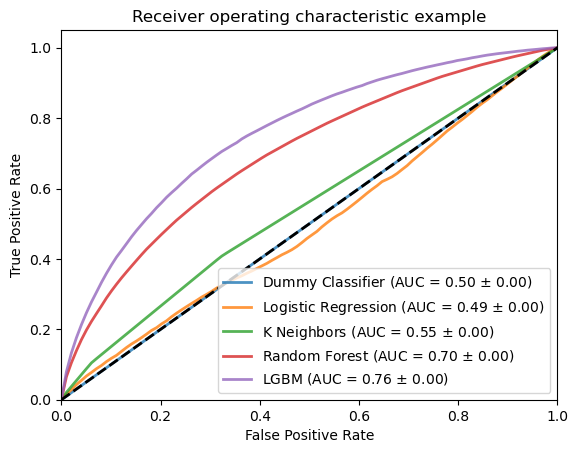

In [14]:
plot_roc_curve(classifiers, X,y , preprocess)

Le classifier LGBM du kernel choisi se confirme le meilleur. Avec le data engineering originel et plus de features le roc-auc était meilleur, mais il reste acceptable.

#### Sur les données debug equilibrés

Testing Dummy Classifier
 Auc fold 0 : 0.5
 Auc fold 1 : 0.5
 Auc fold 2 : 0.5
 Auc fold 3 : 0.5
 Auc fold 4 : 0.5
 Auc fold 5 : 0.5
Dummy Classifier - done in 2s
Testing Logistic Regression


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 0 : 0.5905799398333315


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 1 : 0.5866325869393045


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 2 : 0.5842092383872407


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 3 : 0.5895748535939691


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 4 : 0.6031551298611432


/Users/mcBedini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Auc fold 5 : 0.5916965244785997
Logistic Regression - done in 3s
Testing K Neighbors
 Auc fold 0 : 0.5686038336080407
 Auc fold 1 : 0.5681323349413204
 Auc fold 2 : 0.5634667703070346
 Auc fold 3 : 0.5696685304089575
 Auc fold 4 : 0.5806463936430318
 Auc fold 5 : 0.5917116636508474
K Neighbors - done in 3s
Testing Random Forest
 Auc fold 0 : 0.7027044744637446
 Auc fold 1 : 0.7149715602275182
 Auc fold 2 : 0.7353399260122929
 Auc fold 3 : 0.7186174028016626
 Auc fold 4 : 0.7332058460580338
 Auc fold 5 : 0.7364659404670074
Random Forest - done in 25s
Testing LGBM
 Auc fold 0 : 0.7253138002973756
 Auc fold 1 : 0.7208179134566923
 Auc fold 2 : 0.7306343654186639
 Auc fold 3 : 0.728233535262753
 Auc fold 4 : 0.731467972966739
 Auc fold 5 : 0.7342570631447665
LGBM - done in 6s


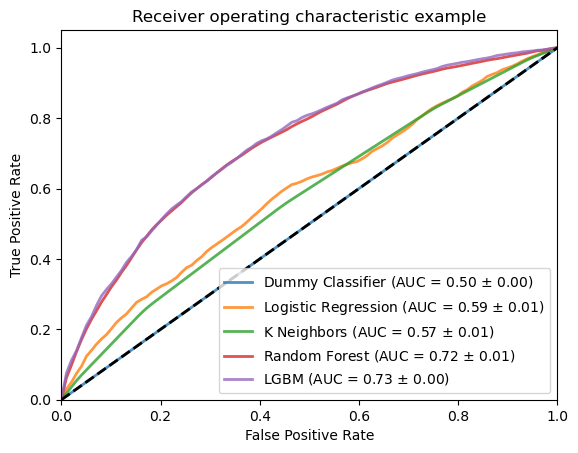

In [15]:
plot_roc_curve(classifiers, X50,y50, preprocess)

In [16]:
#sauvegarde du fichier debug équilibré, pour des tests
df50.to_csv('df50.csv', index= False)


# Test avec Synthetic Minority Oversampling TEchnique (SMOTE)

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html


In [18]:
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE


In [20]:
smote_preprocess  = imbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('smote', SMOTE(random_state=42))
])

# transform the dataset (sklearn n'accepte pas un epipeline SMOTE https://stackoverflow.com/questions/58825053/smote-function-not-working-in-make-pipeline )

smote_X, smote_y = smote_preprocess.fit_resample(X, y)
smote_y.value_counts()



0.0    282682
1.0    282682
Name: TARGET, dtype: int64

In [31]:
smoteX_df=pd.DataFrame(data=smote_X, columns=X.columns)


Testing LGBM
 Auc fold 0 : 0.9779542722546302
 Auc fold 1 : 0.977883768425329
 Auc fold 2 : 0.9777555831026433
 Auc fold 3 : 0.9781246796903738
 Auc fold 4 : 0.978266475853564
 Auc fold 5 : 0.9766655390450157
LGBM - done in 111s


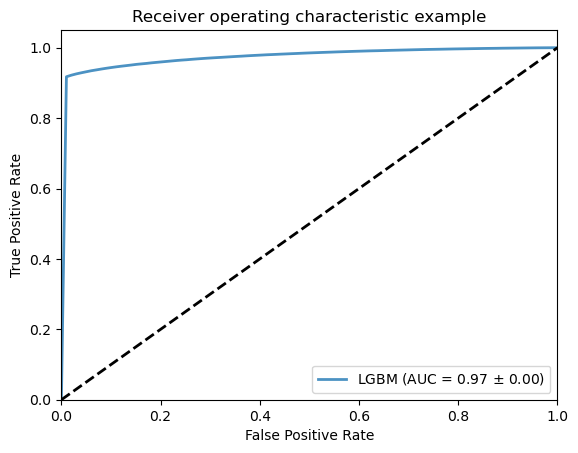

In [30]:
classifier = { 
                'LGBM': LGBMClassifier()
              }

plot_roc_curve(classifier, smoteX_df, smote_y)

# Test de LGBM sans preprocessing

Le roc_auc augmente legerement.

Testing LGBM
 Auc fold 0 : 0.7607125372756675
 Auc fold 1 : 0.7633949429577253
 Auc fold 2 : 0.7601695070171457
 Auc fold 3 : 0.7521636927598606
 Auc fold 4 : 0.7523353613398989
 Auc fold 5 : 0.756200088305869
LGBM - done in 63s


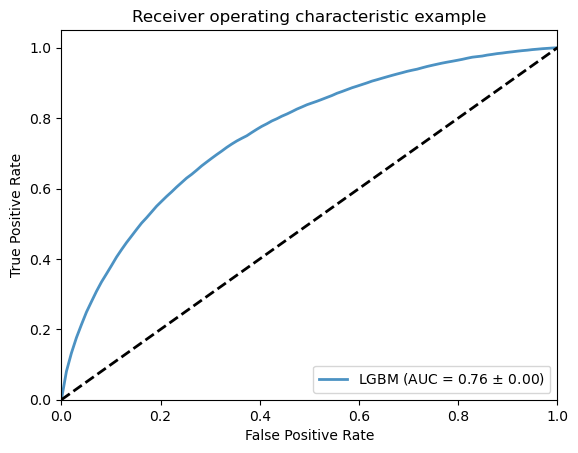

In [32]:
plot_roc_curve(classifier, X, y)

# LGBM permutation importance avec ELI5

Je l'ai utilise pour supprimer quelques features dans le notebook 1




In [17]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

my_model = LGBMClassifier().fit(X_train, y_train)

perm = PermutationImportance(my_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(),top=None)


Weight,Feature
0.0003 ± 0.0002,CREDIT_PRICE_DIFF
0.0002 ± 0.0002,EXT_SOURCES_WEIGHTED
0.0002 ± 0.0001,Pos_MONTHS_BALANCE_MEAN
0.0001 ± 0.0001,Inst_DPD_MEAN
0.0001 ± 0.0002,PAYMENT_RATE
0.0001 ± 0.0001,APARTMENTS_AVG
0.0001 ± 0.0002,DAYS_EMPLOYED
0.0001 ± 0.0002,Buro_CLOSED_DEBT_CREDIT_DIFF_SUM
0.0001 ± 0.0001,REGION_RATING_CLIENT
0.0001 ± 0.0000,Pos_SK_DPD_DEF_MEAN


# Bibliography

Permutation Importance

ELI5

https://www.kaggle.com/code/dansbecker/permutation-importance/tutorial

https://eli5.readthedocs.io/en/latest/

Light gbm

https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html


Auc Roc

https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5


SMOTE